# ENV

In [1]:
#!python -m pip install detectron2==0.4 -f \
#  https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html


In [2]:
!python -m pip install detectron2==0.4 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.6/index.html
     |████████████████████████████████| 5.7 MB 773 kB/s 
     |████████████████████████████████| 47 kB 407 kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58540 sha256=696aa4cfe640c65f3add16e8daef6f901be645fd21b4a9644255c90ec5111289
  Stored in directory: /root/.cache/pip/wheels/a6/02/09/10e3a0150eb92e5ecbee3677a813bffc32a8ec6f876bfe4adf
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=273761 sha256=45264c39fc8afc162aef2ecc62c4c5b0b3754c2d91d1f2bd3889e28fa877147c
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built fvcore pycocotools
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
%pip freeze | grep torch

pytorch-ignite==0.4.2
pytorch-lightning==1.0.4
torch==1.6.0
torchaudio==0.6.0a0+f17ae39
torchtext==0.8.0a0+c851c3e
torchvision==0.7.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
!mkdir -p models logs configs 

In [5]:
!nvidia-smi

Thu Apr 29 16:32:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and utils

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from typing import List, Optional, Union

import torch
import torchvision
import albumentations as A



import detectron2
from detectron2.data.transforms import Transform as T
from detectron2.data.datasets import register_coco_instances
from detectron2.data import transforms as T
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_test_loader , build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import detection_utils as utils
from detectron2.config import configurable
from detectron2.engine.hooks import EvalHook
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.logger import setup_logger
setup_logger()


from sklearn.model_selection import KFold,StratifiedKFold,StratifiedShuffleSplit,GroupKFold
from sklearn.utils import check_random_state
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import cv2
import json
import io
import os
import copy
import random
from IPython.display import FileLink, FileLinks
import yaml
from abc import ABC,ABCMeta, abstractmethod
from yacs.config import CfgNode as CN

# Config

In [7]:
DATASET_PATH = "../input/tacotrashdataset"
LOGS_PATH = "logs"
MODELS_PATH = "models"
CONFIG_PATH = "configs"

In [8]:
_C = CN()
_C.general=CN()
_C.general.seed = 42
_C.general.n_folds = 5
_C.general.tool = "detectron2"
_C.general.experiment_id = "26-04-2021"
_C.general.category = "super_category"
_C.general.augmentations = True
_C.general.TTA = False

_C.preprocess=CN()
_C.preprocess.height = 1500
_C.preprocess.width = 1500
_C.preprocess.longest_max_size = 1500
_C.preprocess.smallest_max_size = 1000

_C.model=CN()
_C.model.base_lr = 0.001
_C.model.num_classes = 29 #29 if super category 60 if normal category 
_C.model.model_name = "faster_rcnn_R_101_FPN_3x"
_C.model.batchsize_per_image = 1024
#_C.model.images_per_batch = 4
_C.model.images_per_batch = 4
_C.model.epochs = 9

In [9]:
def get_cfg_defaults():
    """Get a yacs CfgNode object with default values for my_project."""
    # Return a clone so that the defaults will not be altered
    # This is for the "local variable" use pattern
    #return _C.clone()
    return _C

def dump_cfg(config = get_cfg_defaults() , path = "experiment.yaml"):
    """Save a yacs CfgNode object in a yaml file in path."""
    stream = open(path, 'w')
    stream.write(config.dump())
    stream.close()

def inject_config(funct):
    """Inject a yacs CfgNode object in a function as first arg."""
    def function_wrapper(*args,**kwargs):
        return funct(_C,*args,**kwargs)  
    return function_wrapper

def dump_dict(config,path="config.yaml"):
        stream = open(path, 'w')
        yaml.dump(config,stream)
        stream.close()

c=get_cfg_defaults()

In [10]:
dump_cfg(path = os.path.join(LOGS_PATH , "experiment.yaml"))

# SEED

In [11]:
@inject_config
def seed_all(config):
    """
    seed my experiments to be able to reproduce
    """
    seed_value=config.general["seed"]
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

# FIX annotation duplicated ids and negative bboxes

repeated annotations idx 

308 => 0

4039  =>2197


In [12]:
annot=json.load(open(os.path.join(DATASET_PATH,"data/annotations.json")))
annot["annotations"][308]["id"]=0
annot["annotations"][4039]["id"]=2197

## delete negative BBOX

In [13]:
annot_to_delete=[]
for idx,annotation in enumerate(annot["annotations"]):
    if (annotation["bbox"][0]<0 or annotation["bbox"][1]<0 or
        annotation["bbox"][2]<0 or annotation["bbox"][3]<0):
        annot_to_delete.append(idx)
for pos,idx in enumerate(annot_to_delete):
    del annot["annotations"][idx-pos]


In [14]:
json.dump(annot,open("new_annotations.json","w"))

# Annotation Preprocess and Visualization

## Categories and Super categories dict

In [15]:
categories={ annotation["id"] : annotation["name"] for annotation in annot["categories"]}
super_categories={ annotation["id"] : annotation["supercategory"] for annotation in annot["categories"]}

## Preprocess

In [16]:
annot_df=pd.DataFrame(annot["annotations"])
images_df=pd.DataFrame(annot["images"])

In [17]:
images_df.describe()

,id,width,height
count,1500.000000,1500.00000,1500.000000
mean,749.500000,2824.88400,3222.825333
std,433.157015,758.65017,802.357852
min,0.000000,842.00000,474.000000
25%,374.750000,2448.00000,2448.000000
50%,749.500000,2448.00000,3264.000000
75%,1124.250000,3264.00000,4000.000000
max,1499.000000,6000.00000,5312.000000


### Choose between normal categories or super categories

In [18]:
annot_df["category"]=annot_df["category_id"].apply(lambda value : categories[value])
annot_df["super_category"]=annot_df["category_id"].apply(lambda value : super_categories[value])
super_category_to_index={value : key for key,value in enumerate(annot_df["super_category"].unique())}
annot_df["super_category_id"]=annot_df["super_category"].apply(lambda value : super_category_to_index[value])
annot_df["normal_category_id"]=annot_df["category_id"]
annot_df["normal_category"]=annot_df["category"]
if c.general["category"] != "normal_category":
    annot_df["category_id"]=annot_df["super_category_id"]
    annot_df["category"]=annot_df["super_category"]
    annot_cat=annot_df.groupby("category_id")[["category_id","category","super_category"]].first()
    annot_cat.columns=["id","name","supercategory"]
    annot["categories"]=annot_cat.to_dict("records")

                       

In [19]:
categories = {}
for id , name in zip(annot_df["category_id"],annot_df["category"]):
    categories[id]=name

In [20]:
categories

{0: 'Bottle',
 1: 'Carton',
 2: 'Bottle cap',
 3: 'Can',
 4: 'Pop tab',
 5: 'Cup',
 6: 'Plastic bag & wrapper',
 7: 'Styrofoam piece',
 8: 'Other plastic',
 9: 'Plastic container',
 10: 'Paper',
 11: 'Lid',
 12: 'Straw',
 13: 'Paper bag',
 14: 'Broken glass',
 15: 'Plastic utensils',
 16: 'Glass jar',
 17: 'Food waste',
 18: 'Squeezable tube',
 19: 'Shoe',
 20: 'Aluminium foil',
 21: 'Unlabeled litter',
 22: 'Blister pack',
 23: 'Battery',
 24: 'Rope & strings',
 25: 'Cigarette',
 26: 'Scrap metal',
 27: 'Plastic glooves'}

## Visualization

In [21]:
annot_df.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category,super_category,super_category_id,normal_category_id,normal_category
0,1,0,0,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Bottle,Bottle,0,6,Glass bottle
1,2,1,1,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0,Carton,Carton,1,18,Meal carton
2,3,1,1,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0,Carton,Carton,1,14,Other carton
3,4,2,0,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Bottle,Bottle,0,5,Clear plastic bottle
4,5,2,2,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0,Bottle cap,Bottle cap,2,7,Plastic bottle cap


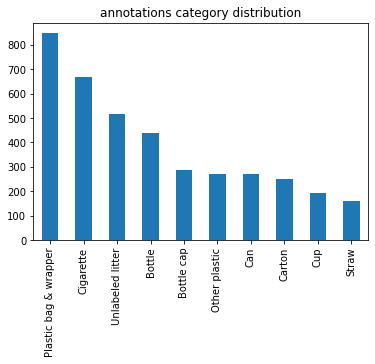

In [22]:
annot_df["category"].value_counts().head(10).plot(kind="bar",title="annotations category distribution")

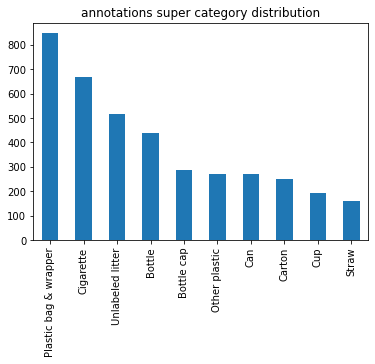

In [23]:
annot_df["super_category"].value_counts().head(10).plot(kind="bar",title="annotations super category distribution")

# Kfold

In [24]:
class RepeatedStratifiedGroupKFold():

    def __init__(self, n_splits=5, n_repeats=1, random_state=None):
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.random_state = random_state
        
    def split(self, X, y=None, groups=None):
        k = self.n_splits
        def eval_y_counts_per_fold(y_counts, fold):
            y_counts_per_fold[fold] += y_counts
            std_per_label = []
            for label in range(labels_num):
                label_std = np.std(
                    [y_counts_per_fold[i][label] / y_distr[label] for i in range(k)]
                )
                std_per_label.append(label_std)
            y_counts_per_fold[fold] -= y_counts
            return np.mean(std_per_label)
            
        rnd = check_random_state(self.random_state)
        for repeat in range(self.n_repeats):
            #print(np.max(y))
            labels_num = np.max(y) + 1
            y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
            y_distr = Counter()
            for label, g in zip(y, groups):
                y_counts_per_group[g][label] += 1
                y_distr[label] += 1

            y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
            groups_per_fold = defaultdict(set)
        
            groups_and_y_counts = list(y_counts_per_group.items())
            rnd.shuffle(groups_and_y_counts)

            for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
                best_fold = None
                min_eval = None
                for i in range(k):
                    fold_eval = eval_y_counts_per_fold(y_counts, i)
                    if min_eval is None or fold_eval < min_eval:
                        min_eval = fold_eval
                        best_fold = i
                y_counts_per_fold[best_fold] += y_counts
                groups_per_fold[best_fold].add(g)
            
            all_groups = set(groups)
            for i in range(k):
                train_groups = all_groups - groups_per_fold[i]
                test_groups = groups_per_fold[i]

                train_indices = [i for i, g in enumerate(groups) if g in train_groups]
                test_indices = [i for i, g in enumerate(groups) if g in test_groups]

                yield train_indices, test_indices


In [25]:
@inject_config
def kfold_split(config,df):
    seed_all()
    df["folds"]=-1
    #kf = GroupKFold(n_splits=config.general["n_folds"])
    kf = RepeatedStratifiedGroupKFold(n_splits=config.general["n_folds"], random_state=config.general["seed"])
    #for fold, (_, val_index) in enumerate(kf.split(df,groups=df["image_id"])):
    for fold, (_, val_index) in enumerate(kf.split(df,df.category_id, df.image_id)):
            df.loc[val_index, "folds"] = fold
    return df

In [26]:
annot_df=kfold_split(annot_df)

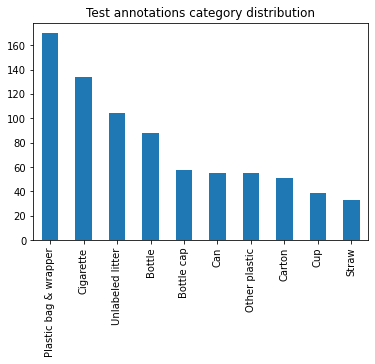

In [27]:
annot_df[annot_df["folds"]==0]["category"].value_counts().head(10).plot(kind="bar",title="Test annotations category distribution")

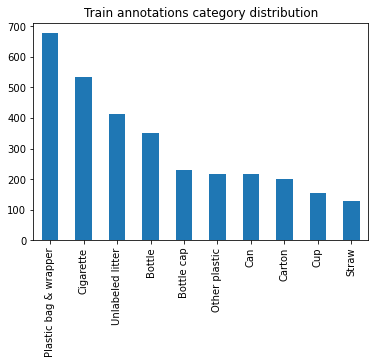

In [28]:
annot_df[annot_df["folds"]!=0]["category"].value_counts().head(10).plot(kind="bar",title="Train annotations category distribution")

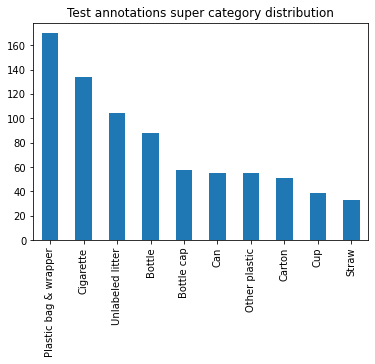

In [29]:
annot_df[annot_df["folds"]==0]["super_category"].value_counts().head(10).plot(kind="bar",title="Test annotations super category distribution")

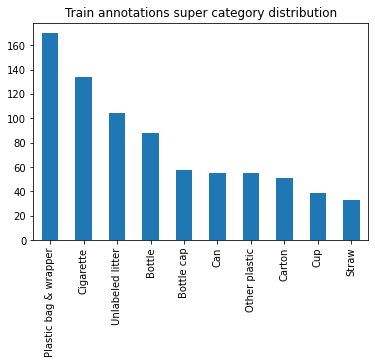

In [30]:
annot_df[annot_df["folds"]==0]["super_category"].value_counts().head(10).plot(kind="bar",title="Train annotations super category distribution")

# Register Dataset

In [31]:
@inject_config
def register_dataset(config,fold):
    train_dataset_name=f"my_dataset_train_{fold}"
    test_dataset_name=f"my_dataset_test_{fold}"
    train_dataset_file=f"my_dataset_train_{fold}.json"
    test_dataset_file=f"my_dataset_test_{fold}.json"
    
    train_annot_df=annot_df[annot_df["folds"]!=fold]
    test_annot_df=annot_df[annot_df["folds"]==fold]
    train_annot_df=train_annot_df.drop(["normal_category","normal_category_id"],axis=1)
    test_annot_df=test_annot_df.drop(["normal_category","normal_category_id"],axis=1)

    train_images_df=images_df[images_df["id"].apply(lambda i:True if i in list(train_annot_df["image_id"].unique()) else False)]
    test_images_df=images_df[images_df["id"].apply(lambda i:True if i in list(test_annot_df["image_id"].unique()) else False)]
    
    train_annot=annot.copy()
    test_annot=annot.copy()
    
    train_annot["annotations"]=train_annot_df.reset_index(drop=True).to_dict("records")
    train_annot["images"]=train_images_df.reset_index(drop=True).to_dict("records")
    test_annot["annotations"]=test_annot_df.reset_index(drop=True).to_dict("records")
    test_annot["images"]=test_images_df.reset_index(drop=True).to_dict("records")
    
    json.dump(train_annot,open(train_dataset_file,"w"))
    json.dump(test_annot,open(test_dataset_file,"w"))
    
    if train_dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(train_dataset_name)
        MetadataCatalog.remove(train_dataset_name)
    if test_dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(test_dataset_name)
        MetadataCatalog.remove(test_dataset_name)
        
    register_coco_instances(train_dataset_name, {}, train_dataset_file, os.path.join(DATASET_PATH,"data"))
    register_coco_instances(test_dataset_name, {}, test_dataset_file, os.path.join(DATASET_PATH,"data"))


# Preprocess and augmentations 

In [32]:
@inject_config
def get_train_transforms(config):
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit= 0.1, 
                                     val_shift_limit=0.1, p=0.8),
                A.RandomBrightnessContrast(brightness_limit=0.3, 
                                           contrast_limit=0.2, p=0.8),
            ],p=0.7),
            A.Rotate (limit=15, interpolation=1, border_mode=4, value=None, mask_value=None, p=0.8),
            
            
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomResizedCrop (config.preprocess.height, config.preprocess.width, scale=(0.8, 0.8), ratio=(0.75, 1.3333333333333333), interpolation=1, always_apply=False, p=0.1),
            A.OneOf([
            A.Resize(height=config.preprocess.height, width=config.preprocess.width, p=0.2),
            A.LongestMaxSize(max_size=config.preprocess.longest_max_size, p=0.2),
            A.SmallestMaxSize(max_size=config.preprocess.smallest_max_size, p=0.2),
                
            ], p=1),
            A.CLAHE(clip_limit=[1,4],p=1),
            
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='coco',
            min_area=0.5, 
            min_visibility=0.5,
            label_fields=['category_id']
        )
    )

@inject_config
def get_valid_transforms(config):
    return A.Compose(
        [
            A.SmallestMaxSize(max_size=config.preprocess.smallest_max_size, p=1.0),
            A.CLAHE(clip_limit=[3,3],p=1),   
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='coco',
            min_area=0.5, 
            min_visibility=0.5,
            label_fields=['category_id']
        )
    )

def get_transforms(train=True):
    if (train):
        return get_train_transforms()
    return get_valid_transforms()
albu_transformations=get_transforms(train=True)

# Personal mapper

In [33]:
class PersonalMapper (detectron2.data.DatasetMapper):
    """
    Define a detectron2 personal mapper in order to be able to use albumentation augmentations
    """
    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
        #utils.check_image_size(dataset_dict, image)

        
        
        ##### ADDED PART

        #print("dataset dict : ",dataset_dict)

        annos = [
            obj for obj in dataset_dict["annotations"]
        ]
        annos_bbox = [
            obj["bbox"] for obj in dataset_dict["annotations"]
        ]
        annos_categroy_id = [
            obj["category_id"] for obj in dataset_dict.pop("annotations")
        ]
        
        if albu_transformations is not None:
            transform_list=get_transforms(self.is_train)
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transform_result=transform_list(image=image,bboxes=annos_bbox,category_id=annos_categroy_id)
            image=cv2.cvtColor(transform_result["image"], cv2.COLOR_RGB2BGR)
            annos=[annos[i] for i in range(len(transform_result["bboxes"]))]
            for i in range(len(annos)):
                annos[i]["bbox"]=list(transform_result["bboxes"][i])
                annos[i]["category_id"]=transform_result["category_id"][i]
        
        dataset_dict["annotations"]=annos
        
        
        ##### ADDED PART
        
        # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in dataset_dict:
            sem_seg_gt = utils.read_image(dataset_dict.pop("sem_seg_file_name"), "L").squeeze(2)
        else:
            sem_seg_gt = None

        aug_input = T.AugInput(image, sem_seg=sem_seg_gt)
        transforms = self.augmentations(aug_input)
        image, sem_seg_gt = aug_input.image, aug_input.sem_seg

        image_shape = image.shape[:2]  # h, w
        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
        if sem_seg_gt is not None:
            dataset_dict["sem_seg"] = torch.as_tensor(sem_seg_gt.astype("long"))

        # USER: Remove if you don't use pre-computed proposals.
        # Most users would not need this feature.
        if self.proposal_topk is not None:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, proposal_topk=self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.use_instance_mask:
                    anno.pop("segmentation", None)
                if not self.use_keypoint:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.instance_mask_format
            )

            # After transforms such as cropping are applied, the bounding box may no longer
            # tightly bound the object. As an example, imagine a triangle object
            # [(0,0), (2,0), (0,2)] cropped by a box [(1,0),(2,2)] (XYXY format). The tight
            # bounding box of the cropped triangle should be [(1,0),(2,1)], which is not equal to
            # the intersection of original bounding box and the cropping box.
            if self.recompute_boxes:
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

# Build Trainer

In [34]:
class PersonalTrainer (detectron2.engine.defaults.DefaultTrainer):
    """
    Personal trainer based on detectron2 DefaultTrainer to add some hooks and change data loaders
    """
    
    def __init__(self, cfg , config=c):
        super().__init__(cfg)
        self.metric=0
        self.checkpointer.save_dir=MODELS_PATH

        
    def build_hooks(self):
        hooks = super().build_hooks()
        def save_best_model():
            
            metric=self.test(self.cfg, self.model)["bbox"]["AP50"]
            if(metric>self.metric):
                self.metric=metric
                self.checkpointer.save("best_model") # it will add .pth alone
                
        steps_per_epoch=annot_df.shape[0]//c.model["images_per_batch"]
        model_checkpointer=EvalHook(steps_per_epoch, save_best_model)
        hooks.insert(-1,model_checkpointer)
        return hooks
    
    @classmethod
    def build_train_loader(cls, cfg):
        
        #return build_detection_train_loader(cfg,mapper=DatasetMapper(cfg,is_train=True,))
        return build_detection_train_loader(cfg,mapper=PersonalMapper(cfg,is_train=True,augmentations=[]))
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        
        #return build_detection_test_loader( cfg,dataset_name,mapper=DatasetMapper(cfg,is_train=False,))
        return build_detection_test_loader( cfg,dataset_name,mapper=PersonalMapper(cfg,is_train=False,augmentations=[]))

    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=None)

# Prepare config params

In [35]:
@inject_config
def get_config(config,fold=0):
    """
    Detectron2 config
    """
    steps_per_epoch=annot_df.shape[0]//config.model["images_per_batch"]
    train_dataset_name=f"my_dataset_train_{fold}"
    test_dataset_name=f"my_dataset_test_{fold}"
    cfg = get_cfg()
    cfg.MODEL.DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
    cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{config.model['model_name']}.yaml"))
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = (test_dataset_name,)
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{config.model['model_name']}.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = config.model["images_per_batch"]
    cfg.SOLVER.BASE_LR = config.model["base_lr"]  # pick a good LR
    cfg.SOLVER.MAX_ITER = steps_per_epoch*config.model["epochs"]  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = (steps_per_epoch*8,)
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.model["batchsize_per_image"]   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = config.model["num_classes"]  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    cfg.TEST.EVAL_PERIOD=0
    cfg.OUTPUT_DIR = LOGS_PATH
    cfg.OUTPUT_DIR_BEST = LOGS_PATH
    cfg.SOLVER.AMP.ENABLED = True
    #cfg.MODEL.WEIGHTS = "../input/trash-taco-heavy-augs/models/best_model.pth"

    cfg.SEED = config.general["seed"]

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    os.makedirs(cfg.OUTPUT_DIR_BEST, exist_ok=True)
    return cfg


In [36]:
cfg=get_config()

# Prepare trainer

In [37]:
def train(fold):
    """
    train function that help train on the dataset and validate on a certain fold
    """
    seed_all()
    register_dataset(fold)
    cfg=get_config(fold)
    #trainer = DefaultTrainer(cfg)
    trainer = PersonalTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.evaluator = COCOEvaluator(f"my_dataset_test_{fold}", ("bbox",), False, output_dir=None)
    trainer.train()
    

In [38]:
train(0)

[04/29 16:32:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:39, 6.13MB/s]                           


[04/29 16:33:28 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  num_fg = fg_inds.nonzero().numel()
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[04/29 16:34:25 d2.utils.events]:  eta: 7:50:01  iter: 19  total_loss: 3.657  loss_cls: 3.423  loss_box_reg: 0.0665  loss_rpn_cls: 0.1037  loss_rpn_loc: 0.02516  time: 2.6491  data_time: 0.1686  lr: 1.9981e-05  max_mem: 9677M
[04/29 16:35:20 d2.utils.events]:  eta: 7:46:53  iter: 39  total_loss: 2.938  loss_cls: 2.686  loss_box_reg: 0.06362  loss_rpn_cls: 0.07668  loss_rpn_loc: 0.04147  time: 2.6824  data_time: 0.0132  lr: 3.9961e-05  max_mem: 9678M
[04/29 16:36:13 d2.utils.events]:  eta: 7:43:44  iter: 59  total_loss: 1.289  loss_cls: 0.8702  loss_box_reg: 0.06598  loss_rpn_cls: 0.1518  loss_rpn_loc: 0.0309  time: 2.6812  data_time: 0.0161  lr: 5.9941e-05  max_mem: 9678M
[04/29 16:37:06 d2.utils.events]:  eta: 7:42:16  iter: 79  total_loss: 0.4463  loss_cls: 0.1933  loss_box_reg: 0.07843  loss_rpn_cls: 0.06827  loss_rpn_loc: 0.05585  time: 2.6675  data_time: 0.0148  lr: 7.9921e-05  max_mem: 9678M
[04/29 16:37:57 d2.utils.events]:  eta: 7:39:34  iter: 99  total_loss: 0.2049  loss_cls: 

# Prepare Output

In [39]:
with open(os.path.join(CONFIG_PATH,"detectron_config.yaml"),"w") as f:
    f.write(get_config().dump())

In [40]:
%ls logs

events.out.tfevents.1619713967.fe1403dc9858.17.0  experiment.yaml  metrics.json


In [41]:
%ls models

best_model.pth   model_0004999.pth  model_final.pth
last_checkpoint  model_0009999.pth


In [42]:
%ls configs

detectron_config.yaml


# Test Dataset (without validation augmentation)

In [43]:
metrics={}

In [44]:
cfg=get_config()
cfg.MODEL.WEIGHTS = os.path.join(MODELS_PATH, "best_model.pth")  # path to the model we just trained
model = build_model(cfg)
m=DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

In [45]:
evaluator = COCOEvaluator("my_dataset_test_0", ("bbox",), False, output_dir=LOGS_PATH)
val_loader = build_detection_test_loader(cfg, "my_dataset_test_0")
train_metric=inference_on_dataset(model, val_loader, evaluator)
metrics["train_metric"]=train_metric

WARNING [04/30 00:38:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 00:38:15 d2.data.datasets.coco]: Loaded 310 images in COCO format from my_dataset_test_0.json
[04/30 00:38:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/30 00:38:15 d2.data.common]: Serializing 310 elements to byte tensors and concatenating them all ...
[04/30 00:38:15 d2.data.common]: Serialized dataset takes 0.43 MiB
[04/30 00:38:15 d2.evaluation.evaluator]: Start inference on 310 images
[04/30 00:38:18 d2.evaluation.evaluator]: Inference done 11/310. 0.1268 s / img. ETA=0:01:11
[04/30 00:38:23 d2.evaluation.evaluator]: Inference done 29/310. 0.1294 s / img. ETA=0:01:17
[04/30 00:38:29 d2.evaluation.evaluator]: Inference done 42/310. 0.1275 s / img. ETA=0:01:30
[04/30 00:38:34 d2.evaluation.evaluator]: Inference done 54

In [46]:
evaluator = COCOEvaluator("my_dataset_train_0", ("bbox",), False, output_dir=LOGS_PATH)
val_loader = build_detection_test_loader(cfg, "my_dataset_train_0")
valid_metric=inference_on_dataset(model, val_loader, evaluator)
metrics["valid_metric"]=valid_metric

WARNING [04/30 00:40:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 00:40:03 d2.data.datasets.coco]: Loaded 1190 images in COCO format from my_dataset_train_0.json
[04/30 00:40:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/30 00:40:03 d2.data.common]: Serializing 1190 elements to byte tensors and concatenating them all ...
[04/30 00:40:03 d2.data.common]: Serialized dataset takes 1.80 MiB
[04/30 00:40:03 d2.evaluation.evaluator]: Start inference on 1190 images
[04/30 00:40:06 d2.evaluation.evaluator]: Inference done 12/1190. 0.1222 s / img. ETA=0:02:56
[04/30 00:40:11 d2.evaluation.evaluator]: Inference done 40/1190. 0.1220 s / img. ETA=0:03:29
[04/30 00:40:16 d2.evaluation.evaluator]: Inference done 60/1190. 0.1270 s / img. ETA=0:03:59
[04/30 00:40:22 d2.evaluation.evaluator]: Inference 

In [47]:
dump_dict(metrics,os.path.join(LOGS_PATH,"metrics.yaml"))